How long will the bond become mature? (in years)
10
How long is each period? (in months)
1
What is the current Stock Price?
100
What is the riskless interest rate per period? (% p.a.)
1
What is the strike price
105
What is the Volatility of the stock?(% p.a.)
10
What is the speed of the reversion to the mean?(% p.a.)
10
What is the initial forward rate of the stock?(% p.a.)
5
How many scenarios you would like to simulate?
100
What’s today’s date?(type day first, then month, and then year)
What's date today?(type day only)13
What's the month today?5
What's the year today?2020


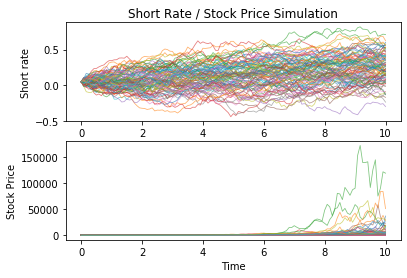

The average of the call price is : 45679.11101122692.
The average of the put price is : 45610.736403477706.


In [1]:
import QuantLib as ql
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# GBM's State Variables
print("How long will the bond become mature? (in years)")
time_to_maturity = float(input())
print("How long is each period? (in months)")
time_unit = float(input())/12
print("What is the current Stock Price?")
S0 = float(input())
print("What is the riskless interest rate per period? (% p.a.)")
risk_free_rate = float(input())/100
print("What is the strike price")
strike_price = float(input())

# parameter of Hull White Process
print("What is the Volatility of the stock?(% p.a.)")
sigma = float(input())/100
print("What is the speed of the reversion to the mean?(% p.a.)")
a = float(input())/100
print("What is the initial forward rate of the stock?(% p.a.)")
forward_rate = float(input())/100
print("How many scenarios you would like to simulate?")
num_paths = int(input())
print("What’s today’s date?(type day first, then month, and then year)")

day, month, year = int(input("What's date today?(type day only)")), int(input("What's the month today?")), int(input("What's the year today?")) 
todays_date = ql.Date(day, month, year)
day_count = ql.Thirty360()

timestep = round(time_to_maturity/time_unit) #timestep=360


#將上述模擬一條路徑的程式碼打包到一個function中，依據使用者輸入想要模擬的次數用迴圈執行Monte Carlo，產生多個路徑以及每個路徑的折現價格(價值)
def Simulate(time_to_maturity, time_unit, S0, risk_free_rate, strike_price, sigma, a, forward_rate, todays_date):
    
    # 模擬不同期的interest rate
    ql.Settings.instance().evaluationDate = todays_date
    spot_curve = ql.FlatForward(todays_date, ql.QuoteHandle(ql.SimpleQuote(forward_rate)), day_count)
    spot_curve_handle = ql.YieldTermStructureHandle(spot_curve)
    
    hw_process = ql.HullWhiteProcess(spot_curve_handle, a, sigma)
    rng = ql.GaussianRandomSequenceGenerator(ql.UniformRandomSequenceGenerator(timestep, ql.UniformRandomGenerator()))
    seq = ql.GaussianPathGenerator(hw_process, time_to_maturity, timestep, rng, False)
    
    def generate_short_rate(timestep):
        sample_path = seq.next()
        path = sample_path.value()
        time = [path.time(j) for j in range(len(path))]
        value = [path[j] for j in range(len(path))]
        r = np.array(value)
        return np.array(time), r
    
    time, r = generate_short_rate(timestep)
    plt.subplot(2, 1, 1)
    plt.plot(time, r, lw=0.8, alpha=0.6)
    plt.title("Short Rate / Stock Price Simulation")
    plt.ylabel('Short rate')
    
    # 模擬不同期的stock price (將上面模擬出來不同期的interest rate代入)
    S = []
    n = round(time_to_maturity/time_unit)
    W = [0] + np.random.standard_normal(size = 1) # size=n，模擬「不同期的變化會不同」
    W = float(W)
    for i in range(len(time)):
        X = (float(r[i])-0.5*sigma**2)*float(time[i]) + sigma*W  #即老師Week6講義的第29頁第一式子exp裡面的東西
        S.append(S0*np.exp(X))  #即老師Week6講義的第29頁第一式子exp之外剩餘的東西
        W = (W + np.random.standard_normal(size = 1))*np.sqrt(time_unit)
        W = float(W)
    plt.subplot(2, 1, 2)
    plt.plot(time, S, lw=0.8, alpha=0.6)
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    
    # 依據模擬出來最後一期的stock price計算payoff，折現回本期加總即為此次債券模擬出來的當期價格
    pay_offs = 0
    total_scenarios = len(S)
    for i in range(total_scenarios):
        price = S[i]
        pay_off = price - strike_price
        if(pay_off>0): 
            pay_offs = pay_offs + np.exp(-1.0*risk_free_rate*i)*pay_off 
    return pay_offs


call_price = []
for i in range(num_paths):
    call_price.append(Simulate(time_to_maturity = time_to_maturity, time_unit = time_unit, S0 = S0, risk_free_rate = risk_free_rate, strike_price = strike_price, sigma = sigma, a = a, forward_rate = forward_rate, todays_date = todays_date))

plt.show()
call_price = sum(call_price) / len(call_price)
print("The average of the call price is : {}.".format(call_price))

put_price = call_price + strike_price * np.exp(-risk_free_rate*timestep) - S0
print("The average of the put price is : {}.".format(put_price))